### Cell below downloads dataset from GDrive

In [ ]:
import requests
import tarfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '0BxYys69jI14kYVM3aVhKS1VhRUk'
destination = 'UTKFace.tar.gz'
download_file_from_google_drive(file_id, destination)

tar = tarfile.open('UTKFace.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [63]:
!ls

sample_data  UTKFace  UTKFace.pkl  UTKFace.tar.gz


In [0]:
from IPython.core.debugger import set_trace

from glob import glob
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm

from mtcnn.mtcnn import MTCNN
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [65]:
# Create DataFrame from files
df = pd.DataFrame()
for i, path in enumerate(glob('UTKFace/*jpg')):
    df.loc[i, 'path'] = path
    
for i in tqdm(df.index):
    path = df.loc[i,'path']
    gender = path.split('/')[1].split('_')[1]
    age = path.split('/')[1].split('_')[0]
    etnicity = path.split('/')[1].split('_')[2]
    df.loc[i, 'gender'] = gender
    df.loc[i, 'age'] = age    
    df.loc[i, 'etnicity'] = etnicity

df = df[df.etnicity.apply(lambda x: x.isnumeric())]

df['age'] = df['age'].values.astype('int8')
df['gender'] = df['gender'].values.astype('int8')
df['etnicity'] = df['etnicity'].values.astype('int')
print(df.shape)
print(df.dtypes)
df.describe()



(23705, 4)
path        object
gender        int8
age           int8
etnicity     int64
dtype: object


,gender,age,etnicity
count,23705.000000,23705.000000,23705.000000
mean,0.477283,33.300907,1.269226
std,0.499494,19.885708,1.345638
min,0.000000,1.000000,0.000000
25%,0.000000,23.000000,0.000000
50%,0.000000,29.000000,1.000000
75%,1.000000,45.000000,2.000000
max,1.000000,116.000000,4.000000


In [0]:
df.to_pickle('UTKFace_2.0.pkl')


In [0]:
def resize_img(img, desired_height):
    '''
    Resize image with desired height
    '''
    height, width = img.shape[:2]
    resize_multiple = desired_height/height
    img_height = int(height / resize_multiple)
    img_width = int(height / resize_multiple)
    img = cv2.resize(img, None, fx=resize_multiple, fy=resize_multiple, interpolation=cv2.INTER_AREA)
    return img

def centroid_histogram(clt):
    '''
    Return histogram based on the number of pixels assigned to each cluster.
    '''
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # Normalize the histogram, such that it sums to one.
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist

def get_top_colors(hist, centroids):
    '''
    Return the colors with maximum percentage of area covered in descending order.
    '''
    top1 = np.argsort(hist)[-1]
    top2 = np.argsort(hist)[-2]
    top3 = np.argsort(hist)[-3]
    top4 = np.argsort(hist)[-4]

    col1 = np.uint8(centroids[top1])
    col2 = np.uint8(centroids[top2])
    col3 = np.uint8(centroids[top3])
    col4 = np.uint8(centroids[top4])
    
    return col1, col2, col3, col4

def get_face_coords_MTCNN(img):
    '''
    Returns coordinates for top left and right bottom corners of the face
    '''
    results = detector_MTCNN.detect_faces(img)
    if results != []:
        b = results[0]['box']
        x1 = int(b[0])
        x1 = (x1 if x1>0 else 0)
        
        y1 = int(b[1]) 
        y1 = (y1 if y1>0 else 0)
        
        x2 = int(b[0]) + int(b[2])
        x2 = (x2 if x2<img.shape[1] else img.shape[1])
        
        y2 = int(b[1]) + int(b[3])
        y2 = (y2 if y2<img.shape[0] else img.shape[0])
        return x1, y1, x2, y2
    else: 
        return None, None, None, None
    
def get_face_coords_DLIB(img):
    faceRects = hogFaceDetector(img, 0)
    if len(faceRects) > 0:
        x1 = faceRects[0].left()
        x1 = (x1 if x1>0 else 0)
        
        y1 = faceRects[0].top()
        y1 = (y1 if y1>0 else 0)
        
        x2 = faceRects[0].right()
        x2 = (x2 if x2<img.shape[1] else img.shape[1])
        
        y2 = faceRects[0].bottom()
        y2 = (y2 if y2<img.shape[0] else img.shape[0])
        return x1, y1, x2, y2
    else: 
        return None, None, None, None
        
        
def get_HSV_centroid(data_ori):
    '''
    Apply clustering alghoritm to HSV image.
    Returns dominant centroids.
    '''
    # Apply k-Means Clustering to the face to obtain most dominant color.
    clt = KMeans(n_clusters = 3, n_jobs=-1, max_iter=5)
    clt.fit(data_ori)
    centroids = clt.cluster_centers_

    # Get the colors with maximum percentage of area covered in descending order.
    hist = centroid_histogram(clt)
    top1 = np.argsort(hist)[-1]
    top2 = np.argsort(hist)[-2]
    top3 = np.argsort(hist)[-3]
    
    col1_hsv = np.uint8([[centroids[top1]]])
    col2_hsv = np.uint8([[centroids[top2]]])
    col3_hsv = np.uint8([[centroids[top3]]])

    # Transform HSV to RGB colorspace
    col1_rgb = cv2.cvtColor(col1_hsv, cv2.COLOR_HSV2RGB)
    col2_rgb = cv2.cvtColor(col2_hsv, cv2.COLOR_HSV2RGB)
    col3_rgb = cv2.cvtColor(col3_hsv, cv2.COLOR_HSV2RGB)
    
    return col1_hsv, col2_hsv, col3_hsv, col1_rgb, col2_rgb, col3_rgb


def get_GRAYscale_centroid(data_ori):
    '''
    Apply clustering alghoritm to GRAY image.
    Returns dominant centroid.
    '''
    # Apply k-Means Clustering to the face to obtain most dominant color.
    clt = KMeans(n_clusters = 3, n_jobs=-1, max_iter=20, n_init=3)
    clt.fit(data_ori)
    centroids = clt.cluster_centers_

    # Get the colors with maximum percentage of area covered in descending order.
    hist = centroid_histogram(clt)
    top1 = np.argsort(hist)[-1]
    top2 = np.argsort(hist)[-2]
    top3 = np.argsort(hist)[-3]

    col1_gray = np.uint8(centroids[top1])
    col2_gray = np.uint8(centroids[top2])
    col3_gray = np.uint8(centroids[top3])
    return col1_gray, col2_gray, col3_gray
    

def get_colors(img_path, show_gray=False, show_rgb=False):
    img = cv2.imread(img_path)
    img = resize_img(img, 720)
    # 1. Detect the face coords and take out the face from the image
    face_bb = get_face_coords_MTCNN(img)
    x1, y1, x2, y2 = face_bb
    
    if x1 == None:
        return np.nan, np.nan, np.nan, np.nan
    
    # Crop face from image 
    face = img[y1:y2,x1:x2]
    face = resize_img(face, 50)
    
    # 2. Convert to HSV, Reshape image data to the flatten array and apply K-means to HSV image
    face_hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
    data = face_hsv.reshape((face_hsv.shape[0] * face_hsv.shape[1], 3))
    # 3. Apply k-Means Clustering to the face to obtain most dominant color
    col1_hsv, col2_hsv, col3_hsv, col1_rgb, col2_rgb, col3_rgb = get_HSV_centroid(data)
    

    # Same steps for grayscale image
    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    data = face_gray.reshape((face_gray.shape[0] * face_gray.shape[1], 1))
    col1_gray, col2_gray, col3_gray = get_GRAYscale_centroid(data)
    
    # Show images
    if show_rgb == True:
        lo_square1 = np.full((10, 10, 3), col1_rgb, dtype=np.uint8)
        lo_square2 = np.full((10, 10, 3), col2_rgb, dtype=np.uint8)
        lo_square3 = np.full((10, 10, 3), col3_rgb, dtype=np.uint8)
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5, 5))

        print(col1_rgb, col2_rgb, col3_rgb)
        ax1.imshow(face[:,:,[2,1,0]])
        ax2.imshow(lo_square1)
        ax3.imshow(lo_square2)
        ax4.imshow(lo_square3)
        plt.show()
    
    if show_gray == True:
        lo_square1 = np.full((10, 10), col1_gray, dtype=np.uint8)
        lo_square2 = np.full((10, 10), col2_gray, dtype=np.uint8)
        lo_square3 = np.full((10, 10), col3_gray, dtype=np.uint8)
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5, 5))
        print(col1_gray, col2_gray, col3_gray)
    
        ax1.imshow(face_gray, cmap='gray', vmin=0, vmax=255)
        ax2.imshow(lo_square1, cmap='gray', vmin=0, vmax=255)
        ax3.imshow(lo_square2, cmap='gray', vmin=0, vmax=255)
        ax4.imshow(lo_square3, cmap='gray', vmin=0, vmax=255)
        plt.show()
    
    return col1_hsv[0][0], col1_rgb[0][0], col1_gray, face_bb
  

[103] [38] [207]


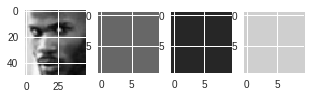

[119] [83] [165]


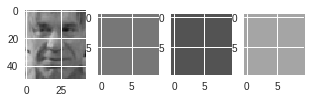

[136] [168] [98]


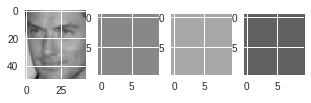

[31] [183] [106]


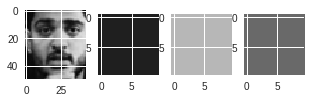

[[[125  87  75]]] [[[48 31 23]]] [[[225 195 169]]]


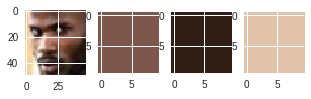

[[[145 100  81]]] [[[189 151 132]]] [[[109  62  44]]]


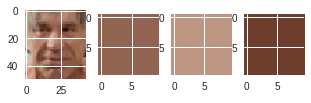

[[[198 137 107]]] [[[140  95  76]]] [[[201 168 173]]]


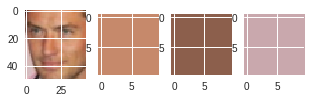

[[[214 155  88]]] [[[84 57 36]]] [[[17 24 20]]]


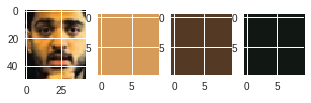

In [134]:
for i in tqdm(df.index[:5]):
    img_path = df.at[i, 'path']
    col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(img_path, show_gray=True)

for i in tqdm(df.index[:5]):
    img_path = df.at[i, 'path']
    col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(img_path, show_rgb=True)
    
    

In [135]:
df['hsv_color'] = None
df['hsv_color'] = df['hsv_color'].astype(object)
df['rgb_color'] = None
df['rgb_color'] = df['rgb_color'].astype(object)
df['gray_color'] = None
df['gray_color'] = df['gray_color'].astype(object)
df['face_bb'] = None
df['face_bb'] = df['face_bb'].astype(object)

for i in tqdm(df.index[:]):
    try:
        img_path = df.at[i, 'path']
        col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(img_path)

        df.at[i, 'hsv_color'] = col1_hsv
        df.at[i, 'rgb_color'] = col1_rgb
        df.at[i, 'gray_color'] = col1_gray
        df.at[i, 'face_bb'] = face_bb
    except Exception as ex:
         print(ex)

df.to_pickle('UTKFace_2.0.pkl')


In [136]:
df.head()

,path,gender,age,etnicity,hsv_color,rgb_color,gray_color,face_bb
0,UTKFace/46_0_3_20170119181027204.jpg.chip.jpg,0,46,3,NaN,NaN,NaN,NaN
1,UTKFace/32_0_1_20170113134657712.jpg.chip.jpg,0,32,1,"[7, 101, 125]","[125, 87, 75]",[103],"(137, 0, 720, 625)"
2,UTKFace/62_0_0_20170111204633236.jpg.chip.jpg,0,62,0,"[9, 113, 145]","[145, 100, 81]",[122],"(44, 0, 664, 708)"
3,UTKFace/40_0_0_20170117152243349.jpg.chip.jpg,0,40,0,"[10, 117, 198]","[198, 137, 107]",[136],"(118, 0, 685, 641)"
4,UTKFace/28_0_4_20170117180230348.jpg.chip.jpg,0,28,4,"[16, 150, 214]","[214, 155, 88]",[32],"(0, 0, 640, 720)"


In [0]:
from google.colab import files
files.download('UTKFace_2.0.pkl')